In [ ]:
import numpy as np
from movement.io import load_poses
import matplotlib.pyplot as plt
import json
from scipy.signal import welch
from movement import sample_data
from movement.filtering import filter_by_confidence, interpolate_over_time
from movement.kinematics import compute_velocity
from movement.filtering import (
    interpolate_over_time,
    rolling_filter,
    savgol_filter,
)
import xarray as xr
from movement.kinematics import (
    compute_forward_vector,
    compute_forward_vector_angle,
)
from movement.plots import plot_centroid_trajectory
from movement.utils.vector import cart2pol, pol2cart
import os
import glob
import pandas as pd
plt.ion()

def plot_raw_and_smooth_timeseries_and_psd(
    ds_raw,
    ds_smooth,
    individual=None,
    keypoint="center",
    space="x",
    time_range=None,
):
    
    # If no individual is specified, use the first one
    if individual is None:
        individual = ds_raw.individuals[0]
    # If no time range is specified, plot the entire time series
    if time_range is None:
        time_range = slice(0, ds_raw.time[-1])

    selection = {
        "time": time_range,
        "individuals": individual,
        "keypoints": keypoint,
        "space": space,
    }

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    for ds, color, label in zip(
        [ds_raw, ds_smooth], ["k", "r"], ["raw", "smooth"], strict=False
    ):
        # plot position time series
        pos = ds.position.sel(**selection)
        ax[0].plot(
            pos.time,
            pos,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

        # interpolate data to remove NaNs in the PSD calculation
        pos_interp = interpolate_over_time(pos, fill_value="extrapolate")

        # compute and plot the PSD
        freq, psd = welch(pos_interp, fs=ds.fps, nperseg=256)
        ax[1].semilogy(
            freq,
            psd,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

    ax[0].set_ylabel(f"{space} position (px)")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_title("Time Domain")
    ax[0].legend()

    ax[1].set_ylabel("PSD (px$^2$/Hz)")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_title("Frequency Domain")
    ax[1].legend()

    plt.tight_layout()
    fig.show()

def ensure_da(arr):
    return arr if hasattr(arr, "plot") else xr.DataArray(arr)

def get_position_values(ds, space):
    space_vals_arr = ds.sel(space=space)
    space_vals = space_vals_arr.values
    space_vals = space_vals.flatten()
    return space_vals

def calculate_hd(position):
    """ Calculating head direction in 3 different methods
    We do -el here, so that the head directions align with the videos
    """
    # Method 1: Orthogonal between left and right ear
    hd_orth_ears = compute_forward_vector_angle(
            position,
            left_keypoint="left_ear",
            right_keypoint="right_ear",
            # Optional parameters:
            reference_vector=(1, 0),  # positive x-axis
            camera_view="top_down",
            in_degrees=False,  # set to True for degrees
    )
    hd_orth_ears = hd_orth_ears.values.flatten()
    hd_orth_ears = [-el for el in hd_orth_ears]

    # Method 2: Headcap to midpoint of ears
    midpoint_ears = position.sel(keypoints=["left_ear", "right_ear"]).mean(dim="keypoints")

    headcap  = position.sel(keypoints="headcap", drop=True)
    headcap_to_midpoint = headcap - midpoint_ears
    hd_cap_mp_polar = cart2pol(headcap_to_midpoint)
    hd_cap_mp = hd_cap_mp_polar.sel(space_pol="phi")
    hd_cap_mp = hd_cap_mp.values.flatten()
    hd_cap_mp = [-el for el in hd_cap_mp]

    # Method 3: Center to midpoint
    head_to_center = headcap - position.sel(keypoints="center")
    hd_cap_center_polar = cart2pol(head_to_center)
    hd_cap_center = hd_cap_center_polar.sel(space_pol="phi")
    hd_cap_center = hd_cap_center.values.flatten()
    hd_cap_center = [-el for el in hd_cap_center]
    return hd_orth_ears, hd_cap_mp, hd_cap_center



def plot_polar_histogram(da, bin_width_deg=15, ax=None):
    """Plot a polar histogram of the data in the given DataArray.

    Parameters
    ----------
    da : xarray.DataArray
        A DataArray containing angle data in radians.
    bin_width_deg : int, optional
        Width of the bins in degrees.
    ax : matplotlib.axes.Axes, optional
        The axes on which to plot the histogram.

    """
    if not hasattr(da, "plot"):
        da = xr.DataArray(da)
    n_bins = int(360 / bin_width_deg)

    if ax is None:
        fig, ax = plt.subplots(  # initialise figure with polar projection
            1, 1, figsize=(5, 5), subplot_kw={"projection": "polar"}
        )
    else:
        fig = ax.figure  # or use the provided axes

    # plot histogram using xarray's built-in histogram function
    da.plot.hist(
        bins=np.linspace(-np.pi, np.pi, n_bins + 1), ax=ax, density=True
    )

    # axes settings
    ax.set_theta_direction(-1)  # theta increases in clockwise direction
    ax.set_theta_offset(0)  # set zero at the right
    ax.set_xlabel("")  # remove default x-label from xarray's plot.hist()

    # set xticks to match the phi values in degrees
    n_xtick_edges = 9
    ax.set_xticks(np.linspace(0, 2 * np.pi, n_xtick_edges)[:-1])
    xticks_in_deg = (
        list(range(0, 180 + 45, 45)) + list(range(0, -180, -45))[-1:0:-1]
    )
    ax.set_xticklabels([str(t) + "\N{DEGREE SIGN}" for t in xticks_in_deg])

    return fig, ax



In [17]:
d = 1
if d == 1:
    folder_directory = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\XY_and_HD\inference_results"
    output_folder = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data"
    trial_numbers = np.arange(1,9)
    name_structure = '1U_02072025.h5'
elif d == 2:
    folder_directory = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-02_date-03072025\all_trials\analysis\spatial_behav_data\XY_and_HD\inference_results"
    output_folder = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-02_date-03072025\all_trials\analysis\spatial_behav_data"
    trial_numbers = np.arange(4,10)
    name_structure = '_1U_July_3_'

frame_rate = 30
keypoints = ['center', 'right_ear', 'left_ear', 'snout', 'headcap']


if not os.path.exists(output_folder):
    os.makedirs(output_folder)

positional_data_folder = os.path.join(output_folder, 'XY_and_HD')
if not os.path.exists(positional_data_folder):
    os.makedirs(positional_data_folder)

movement_data_folder = os.path.join(output_folder, 'movement_plots')
if not os.path.exists(movement_data_folder):
    os.makedirs(movement_data_folder)

trajectory_data_folder = os.path.join(output_folder, 'animal_trajectory')
if not os.path.exists(trajectory_data_folder):
    os.makedirs(trajectory_data_folder)



In [18]:
# Putting in trial number
tr = 1

2025-07-23 10:45:42.504 | WARNING  | movement.io.load_poses:_ds_from_sleap_analysis_file:486 - Could not find SLEAP Track in D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\XY_and_HD\inference_results\T1_1U_02072025.h5. Assuming single-individual dataset and assigning default individual name.
2025-07-23 10:45:42.508 | WARNING  | movement.validators.datasets:__attrs_post_init__:221 - Individual names were not provided. Setting to ['id_0'].


Missing points (marked as NaN) in input:

keypoints                  center             right_ear              left_ear                 snout               headcap
individuals                                                                                                              
id_0         11898/20454 (58.17%)  11937/20454 (58.36%)  11921/20454 (58.28%)  19495/20454 (95.31%)  11941/20454 (58.38%)
Missing points (marked as NaN) in output:

keypoints                  center             right_ear              left_ear                 snout               headcap
individuals                                                                                                              
id_0         11898/20454 (58.17%)  12369/20454 (60.47%)  12500/20454 (61.11%)  20294/20454 (99.22%)  12136/20454 (59.33%)
Missing points (marked as NaN) in input:

keypoints                  center             right_ear              left_ear                 snout               headcap
individuals        

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 20454, space: 2, keypoints: 5, individuals: 1)
Coordinates:
  * time         (time) float64 164kB 0.0 0.03333 0.06667 ... 681.7 681.7 681.8
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U9 180B 'center' 'right_ear' ... 'snout' 'headcap'
  * individuals  (individuals) <U4 16B 'id_0'
Data variables:
    position     (time, space, keypoints, individuals) float32 818kB 803.9 .....
    confidence   (time, keypoints, individuals) float32 409kB 0.8791 ... nan
Attributes:
    source_software:  SLEAP
    ds_type:          poses
    fps:              30.0
    time_unit:        seconds
    source_file:      D:/Spatiotemporal_task/derivatives/sub-002_id-1U/ses-01...

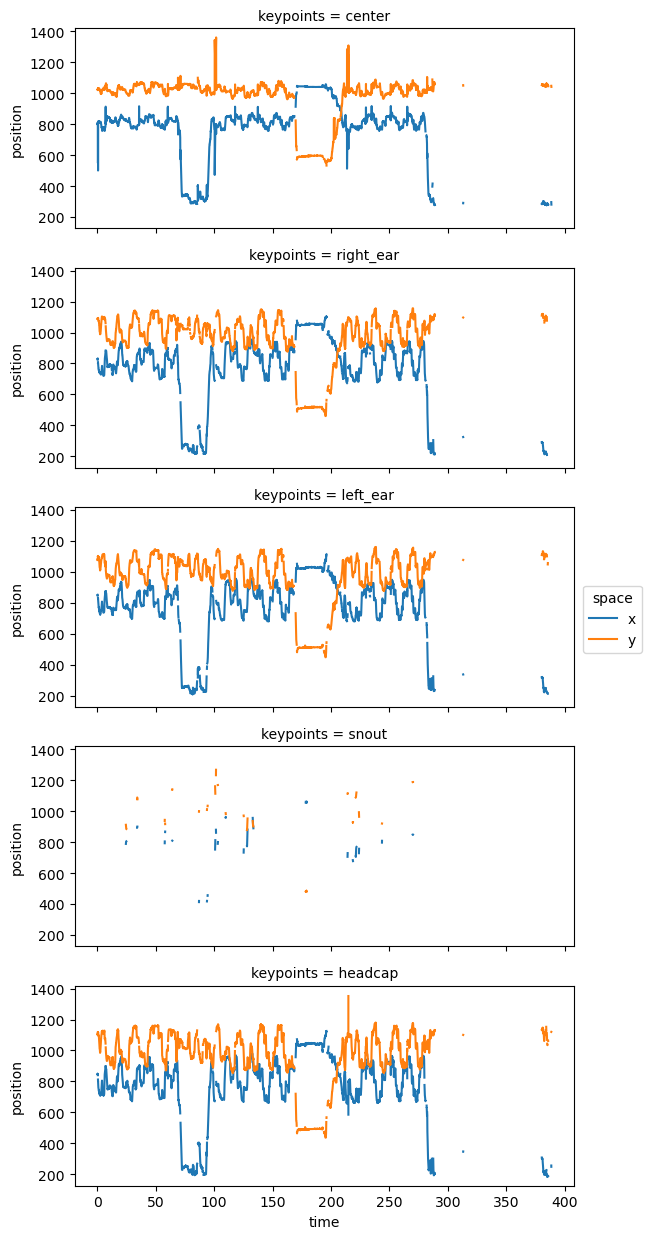

In [19]:

if d == 1:
    file_path = f"{folder_directory}\\T{tr}_{name_structure}"
elif d == 2:
    pattern = os.path.join(folder_directory, f"{name_structure}T{tr}_*.h5")
    matches = glob.glob(pattern)
    file_path = matches[0]

# --------- Loading data --------
ds = load_poses.from_sleap_file(file_path, fps=frame_rate)
position = ds.position


# Filtering by confidence
ds.update(
    {
        "position": filter_by_confidence(
            ds.position, ds.confidence, print_report=True, threshold = 0.6
        )
    }
)
ds.position.squeeze().plot.line(
    x="time", row="keypoints", hue="space", aspect=2, size=2.5
)


# Interpolating over time
ds.update(
    {
        "position": interpolate_over_time(
            ds.position, max_gap=50, print_report=True
        )
    }
)




In [20]:

# ---------- Smoothing ----------
window = int(ds.fps)
ds_smooth = ds.copy()
ds_smooth.update(
    {
        "position": rolling_filter(
            ds.position, window, statistic="median", print_report=True
        )
    }
)


    

Missing points (marked as NaN) in input:

keypoints                  center             right_ear              left_ear                 snout               headcap
individuals                                                                                                              
id_0         11566/20454 (56.55%)  11607/20454 (56.75%)  11574/20454 (56.59%)  20131/20454 (98.42%)  11572/20454 (56.58%)
Missing points (marked as NaN) in output:

keypoints                  center            right_ear              left_ear                 snout               headcap
individuals                                                                                                             
id_0         11642/20454 (56.92%)  11679/20454 (57.1%)  11646/20454 (56.94%)  20389/20454 (99.68%)  11646/20454 (56.94%)


<xarray.Dataset> Size: 1MB
Dimensions:      (time: 20454, space: 2, keypoints: 5, individuals: 1)
Coordinates:
  * time         (time) float64 164kB 0.0 0.03333 0.06667 ... 681.7 681.7 681.8
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U9 180B 'center' 'right_ear' ... 'snout' 'headcap'
  * individuals  (individuals) <U4 16B 'id_0'
Data variables:
    position     (time, space, keypoints, individuals) float32 818kB 802.2 .....
    confidence   (time, keypoints, individuals) float32 409kB 0.8791 ... nan
Attributes:
    source_software:  SLEAP
    ds_type:          poses
    fps:              30.0
    time_unit:        seconds
    source_file:      D:/Spatiotemporal_task/derivatives/sub-002_id-1U/ses-01...

In [21]:
    
#------------- HEAD DIRECTION ----------------
position = ds_smooth.position

hd_orth_ears, hd_cap_mp, hd_cap_center = calculate_hd(position)


In [28]:
hd_orth_ears.values.flatten()

array([1.30362352, 1.30362352, 1.30362352, ...,        nan,        nan,
              nan], shape=(20454,))

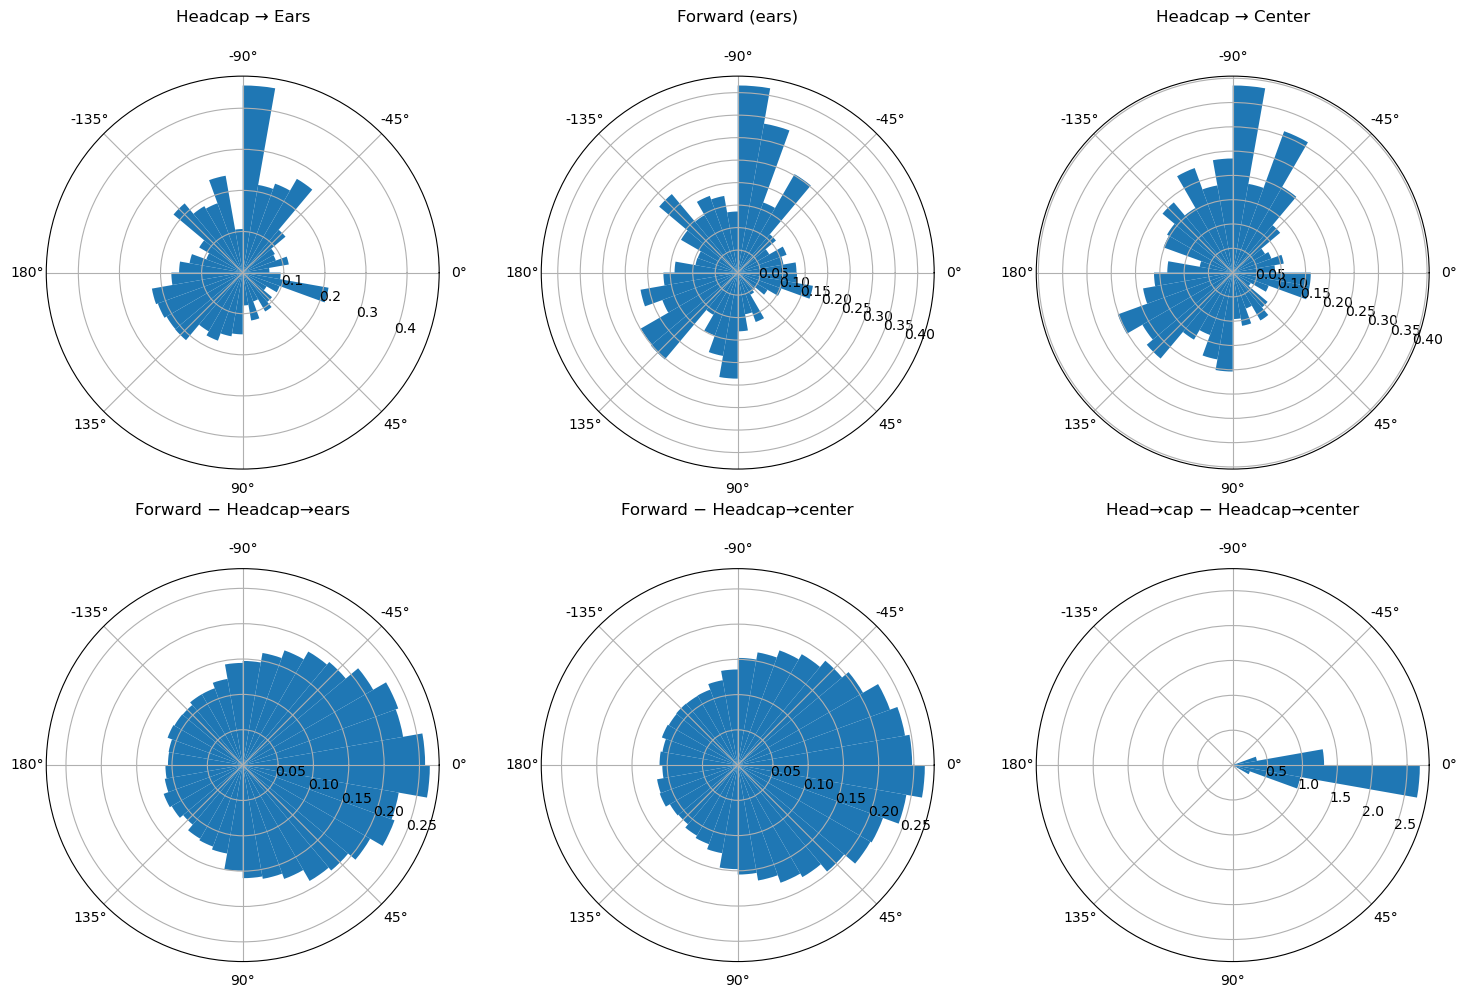

2025-07-23 10:45:49.786 | WARNING  | matplotlib._api:warn_external:391 - C:\Users\Sophia\AppData\Local\Temp\ipykernel_46644\998533035.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_alpha(1)

2025-07-23 10:45:49.851 | WARNING  | matplotlib._api:warn_external:391 - C:\Users\Sophia\AppData\Local\Temp\ipykernel_46644\998533035.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()



D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\animal_trajectory\trajectory_t1.png


In [22]:

# ==== PLOTTING ===
da_forward = ensure_da(hd_orth_ears)
da_headcap = ensure_da(hd_cap_mp)
da_center  = ensure_da(hd_cap_center)

# compute differences
diff_f__h = da_forward - da_headcap
diff_f__c = da_forward - da_center
diff_h__c = da_headcap - da_center

all_das = [da_headcap, da_forward, da_center]
all_labels = ["Headcap → Ears", "Forward (ears)", "Headcap → Center"]
diffs    = [diff_f__h, diff_f__c, diff_h__c]
diff_lbls= [
    "Forward − Headcap→ears",
    "Forward − Headcap→center",
    "Head→cap − Headcap→center",
]

# make one figure with 2 rows x 3 cols
fig, axes = plt.subplots(
    2, 3,
    figsize=(15, 10),
    subplot_kw={"projection": "polar"}
)

# first row: raw distributions
for ax, da, lbl in zip(axes[0], all_das, all_labels):
    plot_polar_histogram(da, bin_width_deg=10, ax=ax)
    #ax.set_ylim(0, 0.25)
    ax.set_title(lbl, pad=20)

# second row: differences
for ax, da_diff, lbl in zip(axes[1], diffs, diff_lbls):
    da_diff = ensure_da(da_diff.values)
    plot_polar_histogram(da_diff, bin_width_deg=10, ax=ax)
    #ax.set_ylim(0, 0.25)
    ax.set_title(lbl, pad=20)
output_path = os.path.join(movement_data_folder , f"t{tr}_headdirection.png")
plt.tight_layout()
plt.show()


# Saving x, y, and hd data

midpoint_ears = position.sel(keypoints=["left_ear", "right_ear"]).mean(dim="keypoints")
x_vals = midpoint_ears.sel(space = 'x')
x =  x_vals.values.flatten()

y_vals = midpoint_ears.sel(space = 'y')
y =  y_vals.values.flatten()   

hd_orth_deg     = np.degrees(hd_orth_ears.values if hasattr(hd_orth_ears, "values") else hd_orth_ears)
hd_cap_mp_deg   = np.degrees(hd_cap_mp)
hd_cap_ctr_deg  = np.degrees(hd_cap_center)

right_ear = position.sel(keypoints = 'right_ear')
right_ear_vals = right_ear.values
coords = right_ear_vals.squeeze(-1) 
x_re, y_re = coords[:, 0], coords[:, 1]

left_ear = position.sel(keypoints = 'left_ear')
left_ear_vals = left_ear.values
coords = left_ear_vals.squeeze(-1) 
x_le, y_le = coords[:, 0], coords[:, 1]

# build a pandas DataFrame
df = pd.DataFrame({
    "x":              x,
    "y":              y,
    "hd_forward":    hd_orth_deg.flatten(),
    "hd_cap_to_ears":hd_cap_mp_deg,
    "hd_cap_to_center":     hd_cap_ctr_deg,
    'x_left_ear': x_le,
    'y_left_ear': y_le,
    'x_right_ear': x_re,
    'y_right_ear': y_re,
})

# save to CSV
csv_path = os.path.join(positional_data_folder, f"XY_HD_t{tr}_full.csv")
#df.to_csv(csv_path, index=False)
#print(f"→ Saved positional + HD data to {csv_path}")


# Plotting trajectory
# Create a single figure and axes
fig, ax = plt.subplots(1, 1)
# Invert y-axis so (0,0) is in the top-left,
# matching typical image coordinate systems
ax.invert_yaxis()
# Plot trajectories for each mouse on the same axes
for rat_name, col in zip(
    position.individuals.values,
    ["r", "g", "b"],  # colours
    strict=False,
):
    plot_centroid_trajectory(
        position,
        individual=rat_name,
        ax=ax,  # Use the same axes for all plots
        c=col,
        marker="o",
        s=10,
        alpha=0.2,
    )
    ax.set_xlim(150,1550)
    ax.set_ylim(250,1750)
    ax.set_aspect('equal', adjustable='box') 
    ax.legend().set_alpha(1)
    ax.set_title(f'Trajectory trial {tr}')
output_path = os.path.join(trajectory_data_folder, f'trajectory_t{tr}.png')
print(output_path)
fig.savefig(output_path)
fig.show()
#input("Press Enter to close plots...")
plt.close('all')

In [23]:
d = [5,5,5]
d 

[5, 5, 5]

In [24]:
# Playing with hd
behav_data_path = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data"
base_path = os.path.join(behav_data_path, 'XY_and_HD')

df_path = os.path.join(base_path, f"XY_HD_t{tr}_full.csv")
df_full = pd.read_csv(df_path)

df_path = os.path.join(base_path, 'three_hd_methods', f"XY_HD_t{tr}.csv")
df_not_full = pd.read_csv(df_path)

df_full

,x,y,hd_forward,hd_cap_to_ears,hd_cap_to_center,x_left_ear,y_left_ear,x_right_ear,y_right_ear
0,838.3578,1087.1086,74.692126,72.89539,63.175934,848.6,1084.3052,828.11554,1089.9121
1,838.3578,1087.1086,74.692126,72.89539,63.175934,848.6,1084.3052,828.11554,1089.9121
2,838.3578,1087.1086,74.692126,72.89539,63.175934,848.6,1084.3052,828.11554,1089.9121
3,838.3578,1087.1086,74.692126,72.89539,63.166473,848.6,1084.3052,828.11554,1089.9121
4,838.3578,1086.8254,76.175762,73.10726,64.141600,848.6,1084.3052,828.11554,1089.3458
...,...,...,...,...,...,...,...,...,...
20449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_not_full

,x,y,hd_forward,hd_cap_to_ears,hd_cap_to_center
0,781.939,1084.7764,133.295555,144.0749,125.59601
1,781.939,1084.7764,133.295555,144.0749,125.59601
2,781.939,1084.7764,133.295555,144.0749,125.59601
3,781.939,1084.7764,133.295555,144.0749,125.59601
4,781.939,1084.7764,133.295555,144.0749,125.58413
...,...,...,...,...,...
20449,NaN,NaN,NaN,NaN,NaN
20450,NaN,NaN,NaN,NaN,NaN
20451,NaN,NaN,NaN,NaN,NaN
20452,NaN,NaN,NaN,NaN,NaN
